In [1]:
from skbio.stats.ordination import OrdinationResults
import pandas as pd
import numpy as np
from plane import point_to_segment_distance
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# clearning metadata from analysis
metadata = pd.read_csv('15093_analysis_mapping.txt.gz', compression='gzip', sep='\t', dtype=str)
metadata.set_index('#SampleID', inplace=True)

In [3]:
pcoa_fp = 'ordination.txt.gz'
pcoa = OrdinationResults.read(pcoa_fp, compression='gzip')
df = metadata.loc[pcoa.samples.index.tolist()]
hc_ids = df[df.diagnosis_simple == 'HC'].index.tolist()
xyz = pcoa.samples.loc[hc_ids].iloc[:,:3].copy()
x = xyz.iloc[:, 0].values
y = xyz.iloc[:, 1].values
z = xyz.iloc[:, 2].values
A = np.column_stack([x, y, np.ones_like(x)])
abd, residuals, rank, s = np.linalg.lstsq(A, z)
abcd = np.insert(abd, 2, -1)
print ('(%f x) + (%f y) + (%f z) + (%f) ' % tuple(abcd))
col_name = 'distance_to_plane'
metadata[col_name] = np.nan
for sid, row in pcoa.samples.iterrows():
    deest = point_to_segment_distance(
            abcd, row[:3].tolist(), np.array([row.tolist() for _, row in xyz.iterrows()]))
    metadata.at[sid, col_name] = str(deest)

metadata['distance_to_plane'] = pd.to_numeric(metadata['distance_to_plane'])

(0.828031 x) + (0.357078 y) + (-1.000000 z) + (0.035064) 


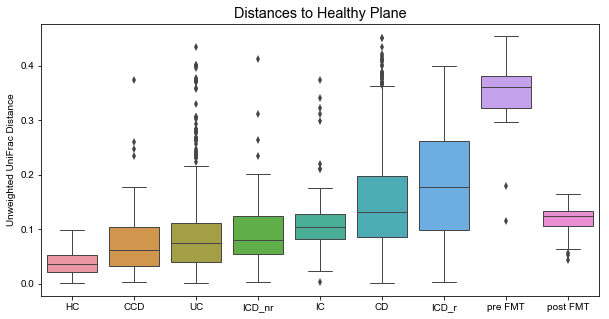

In [4]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

sns.boxplot(x='diagnosis_simple', y='distance_to_plane', data=metadata, 
            order=['HC', 'CCD', 'UC', 'ICD_nr', 'IC', 'CD', 'ICD_r', 'pre FMT', 'post FMT'],
            linewidth=1, ax=axs)
axs.set(title = 'Distances to Healthy Plane', ylabel='Unweighted UniFrac Distance', xlabel="")
fig.savefig("dianosis_simpe.pdf")